In [139]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import seaborn as sns
from string import punctuation
import matplotlib.pyplot as plt
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


> # Loading the preprocessed train and test data

In [140]:
import pickle
df_train=pickle.load(open('../input/fake-news-case-study-preprocessed-daa/df_train.pkl','rb'))

> # Shape of train and test dataset

In [141]:
df_train.shape

(18285, 27)

In [142]:
df_train.head()

,id,title,author,text,label,num_characters_title,num_characters_text,num_word_title,num_word_text,num_sentences_title,...,Avg_sentence_length_title,Avg_sentence_length_text,Stopword_count_ratio_title,Stopword_count_ratio_text,Unique_words_count_ratio_title,Unique_words_count_ratio_text,cleaned_text,cleaned_title,Without_Stopwords_text,Without_Stopwords_title
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,4930,19,943,1,...,19.0,25.486486,0.105263,0.386002,0.947368,0.441145,house dem aide we did not even see comey s let...,house dem aide we did not even see comey s let...,house dem aide even see comey letter jason cha...,house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160,11,822,1,...,11.0,28.344828,0.090909,0.371046,1.000000,0.486618,ever get the feeling your life circles the rou...,flynn hillary clinton big woman on campus brei...,ever get feeling life circles roundabout rathe...,flynn hillary clinton big woman campus breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692,7,1454,1,...,7.0,28.509804,0.142857,0.359697,1.000000,0.416781,why the truth might get you fired october the ...,why the truth might get you fired,truth might get fired october tension intellig...,truth might get fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237,10,612,1,...,10.0,22.666667,0.000000,0.352941,1.000000,0.436275,videos civilians killed in single us airstrike...,civilians killed in single us airstrike have b...,videos civilians killed single us airstrike id...,civilians killed single us airstrike identified
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938,14,177,1,...,14.0,35.400000,0.285714,0.344633,0.857143,0.587571,print an iranian woman has been sentenced to s...,iranian woman jailed for fictional unpublished...,print iranian woman sentenced six years prison...,iranian woman jailed fictional unpublished sto...


> # Extracting independent features on X and Class label to Y variable

In [143]:
Y=df_train["label"]
X=df_train.drop(["id","title","text","label","cleaned_text","cleaned_title","author"], axis=1, inplace=False)

In [144]:
X.shape,Y.shape

((18285, 20), (18285,))

> # Splitting the dataset to train and test dataset

In [145]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y,random_state=42)

In [146]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13713, 20) (13713,)
(4572, 20) (4572,)


In [147]:
X_train.head(1)

,num_characters_title,num_characters_text,num_word_title,num_word_text,num_sentences_title,num_sentences_text,Count_unique_words_title,Count_unique_words_text,Count_Stop_words_title,Count_Stop_words_text,Avg_word_length_title,Avg_word_length_text,Avg_sentence_length_title,Avg_sentence_length_text,Stopword_count_ratio_title,Stopword_count_ratio_text,Unique_words_count_ratio_title,Unique_words_count_ratio_text,Without_Stopwords_text,Without_Stopwords_title
8682,69,287,10,42,1,2,10,36,3,12,6.9,6.833333,10.0,21.0,0.3,0.285714,1.0,0.857143,next swipe left right important question scunt...,important question scunthorpe hospital compute...


> # Extracting numberical features from train andtest dataset

In [148]:
X_train_Num_Ft=X_train.drop(["Without_Stopwords_text","Without_Stopwords_title"],axis=1,inplace=False)
X_test_Num_Ft=X_test.drop(["Without_Stopwords_text","Without_Stopwords_title"],axis=1,inplace=False)

In [149]:
X_train_Num_Ft.shape,X_test_Num_Ft.shape

((13713, 18), (4572, 18))

In [150]:
X_train_Num_Ft.head(1)

,num_characters_title,num_characters_text,num_word_title,num_word_text,num_sentences_title,num_sentences_text,Count_unique_words_title,Count_unique_words_text,Count_Stop_words_title,Count_Stop_words_text,Avg_word_length_title,Avg_word_length_text,Avg_sentence_length_title,Avg_sentence_length_text,Stopword_count_ratio_title,Stopword_count_ratio_text,Unique_words_count_ratio_title,Unique_words_count_ratio_text
8682,69,287,10,42,1,2,10,36,3,12,6.9,6.833333,10.0,21.0,0.3,0.285714,1.0,0.857143


In [151]:
X_test_Num_Ft.head(1)

,num_characters_title,num_characters_text,num_word_title,num_word_text,num_sentences_title,num_sentences_text,Count_unique_words_title,Count_unique_words_text,Count_Stop_words_title,Count_Stop_words_text,Avg_word_length_title,Avg_word_length_text,Avg_sentence_length_title,Avg_sentence_length_text,Stopword_count_ratio_title,Stopword_count_ratio_text,Unique_words_count_ratio_title,Unique_words_count_ratio_text
9013,48,2475,7,477,1,13,7,199,1,155,6.857143,5.188679,7.0,36.692308,0.142857,0.324948,1.0,0.417191


> # Standardization of 18 numerical Manually engineered features

In [152]:
from sklearn.preprocessing  import StandardScaler
Std_Scaler=StandardScaler()
X_train_Num_Std=Std_Scaler.fit_transform(X_train_Num_Ft)
X_test_Num_Std=Std_Scaler.transform(X_test_Num_Ft)

In [153]:
X_train_Num_Std.shape,X_test_Num_Std.shape

((13713, 18), (4572, 18))

In [154]:
X_train_Num_Std

array([[-0.25042064, -0.86483222, -0.88363495, ..., -0.68191916,
         0.58227813,  2.78435809],
       [ 0.32519972, -0.11495737,  0.98084975, ..., -0.03588199,
         0.58227813, -0.40221243],
       [ 0.23664274, -0.12338293, -0.26214005, ...,  0.31702932,
         0.58227813, -0.0891202 ],
       ...,
       [ 0.67942764, -0.88934294,  0.56651982, ...,  1.09183384,
         0.58227813,  2.91913599],
       [ 0.36947821,  0.60600249,  0.35935485, ...,  0.16318966,
        -0.61005025, -0.6306165 ],
       [ 0.28092123, -0.35221348,  0.35935485, ...,  0.09751571,
         0.58227813, -0.07937207]])

In [155]:
X_test_Num_Std

array([[-1.18026892, -0.4458521 , -1.50512985, ..., -0.10457833,
         0.58227813, -0.5362078 ],
       [ 0.59087066, -0.2560855 , -0.26214005, ...,  0.2049075 ,
         0.58227813, -0.08872233],
       [ 0.0152503 ,  0.35361867,  0.15218988, ..., -0.31335738,
        -0.68953881,  0.02916915],
       ...,
       [ 0.4137567 ,  1.07457853,  0.15218988, ..., -0.4009486 ,
         0.58227813, -0.61152672],
       [ 0.05952879, -0.66951242,  0.15218988, ..., -0.50539638,
         0.58227813,  0.83779477],
       [-0.64892705, -0.47687348, -1.09079992, ...,  0.65402768,
         0.58227813,  0.22454754]])

> # 1. Traning Naive bayes model

> # Vectorizing our text features using tfidf vectorizer

In [156]:
vectorizer_tfidf =TfidfVectorizer(max_features=3500)
vectorizer_tfidf.fit(X_train["Without_Stopwords_title"].values)

# we use the fitted tfidfVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer_tfidf.transform(X_train['Without_Stopwords_title']).toarray()
X_test_title_tfidf = vectorizer_tfidf.transform(X_test['Without_Stopwords_title']).toarray()

print("After vectorizations shape of train and test data")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations shape of train and test data
(13713, 3500) (13713,)
(4572, 3500) (4572,)


In [157]:
vectorizer_text_tfidf =TfidfVectorizer(max_features=4500)
vectorizer_text_tfidf.fit(X_train["Without_Stopwords_text"].values)

# we use the fitted countVectorizer to convert the text to vector
X_train_text_tfidf = vectorizer_text_tfidf.transform(X_train['Without_Stopwords_text'].values).toarray()
X_test_text_tfidf = vectorizer_text_tfidf.transform(X_test['Without_Stopwords_text'].values).toarray()

print("After vectorizations shape of train and test data")
print(X_train_text_tfidf.shape, y_train.shape)
print(X_test_text_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations shape of train and test data
(13713, 4500) (13713,)
(4572, 4500) (4572,)


In [158]:
# stacking all the features for train and test dataset 
X_train_final_tfidf = np.hstack((X_train_title_tfidf, X_train_text_tfidf,X_train_Num_Std))
X_test_final_tfidf = np.hstack((X_test_title_tfidf , X_test_text_tfidf,X_test_Num_Std))

print("Final Data matrix")
print(X_train_final_tfidf.shape, y_train.shape)
print(X_test_final_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(13713, 8018) (13713,)
(4572, 8018) (4572,)


# Training the gaussian NB model

In [159]:
gnb = GaussianNB()
gnb.fit(X_train_final_tfidf,y_train)
y_pred = gnb.predict(X_test_final_tfidf)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
print("Gaussian NB accuracy on test dataset :",accuracy)
print("Gaussian NB precision on test dataseet :",precision)

Gaussian NB accuracy on test dataset : 0.8258967629046369
Gaussian NB precision on test dataseet : 0.7716643741403026


> # Plotting confusion mattrix

In [160]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[2093  498]
 [ 298 1683]]


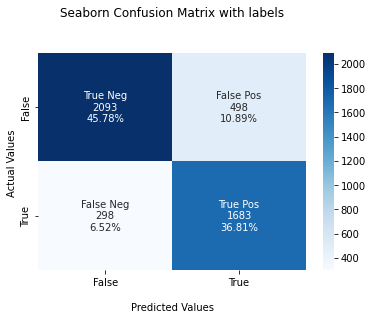

In [161]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

> # k-nearest neighbors Classifier

In [162]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train_final_tfidf,y_train)
y_pred = neigh.predict(X_test_final_tfidf)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
print("k-nearest neighbors accuracy on testdataset :",accuracy)
print("k-nearest neighbors precision on testdataset :",precision)

k-nearest neighbors accuracy on testdataset : 0.8396762904636921
k-nearest neighbors precision on testdataset : 0.8679245283018868


> # Plotting confusion mattrix

In [163]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[2367  224]
 [ 509 1472]]


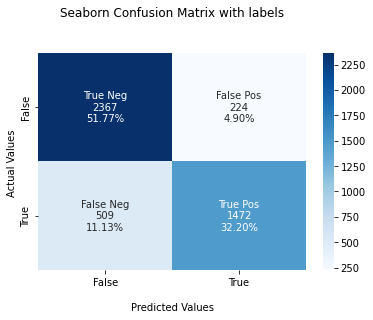

In [164]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

> # Traning KNN on only 18 manually engnieered Numerical features

In [165]:
from sklearn.neighbors import KNeighborsClassifier
neigh_num = KNeighborsClassifier()
neigh_num.fit(X_train_Num_Std,y_train)
y_pred_num = neigh_num.predict(X_test_Num_Std)
accuracy = accuracy_score(y_test,y_pred_num)
precision = precision_score(y_test,y_pred_num)
print("Accuracy of KNN using only 18 manually engineered numercal feaures")
print("*"*100)
print("k-nearest neighbors accuracy on testdataset :",accuracy)
print("k-nearest neighbors precision on testdataset :",precision)

Accuracy of KNN using only 18 manually engineered numercal feaures
****************************************************************************************************
k-nearest neighbors accuracy on testdataset : 0.8112423447069116
k-nearest neighbors precision on testdataset : 0.8288235294117647


# Observations:-
1. Above we have only used manually engineered 18 features to train KNN model and it is perofroming decently
and here we are getting accuracy on test data is 81%.

> # Plotting confusion mattrix

In [166]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_num)

print(cf_matrix)

[[2300  291]
 [ 572 1409]]


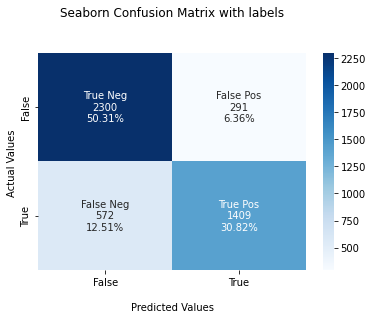

In [167]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

> # Observations:-
1. from above we can see that only 18 numerical feature we are able to get 81% accuracy on test data that show that our manually engineered fearure are able to seperate both classes.

> # 3. Traning Logistic Regression model

In [168]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=12)
LR.fit(X_train_final_tfidf,y_train)
y_pred = LR.predict(X_test_final_tfidf)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
print("LR accuracy on testdataset :",accuracy)
print("LR precision on testdataset :",precision)

LR accuracy on testdataset : 0.976596675415573
LR precision on testdataset : 0.9593137254901961


> # Plotting confusion mattrix

In [169]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[2508   83]
 [  24 1957]]


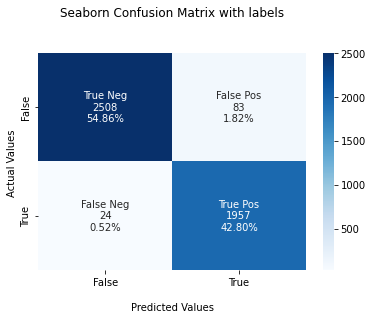

In [170]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

> # Traning Logistic regression only on numerical feaures

In [171]:
LR = LogisticRegression(random_state=12)
LR.fit(X_train_Num_Std,y_train)
y_pred_num = LR.predict(X_test_Num_Std)
accuracy = accuracy_score(y_test,y_pred_num)
precision = precision_score(y_test,y_pred_num)
print("LR accuracy on testdataset :",accuracy)
print("LR precision on testdataset :",precision)

LR accuracy on testdataset : 0.7569991251093613
LR precision on testdataset : 0.7645985401459854


# Observations:-
1. Here again we used only 18 numerical feaures to train Logistic regression and it is not performing that well as comppare to KNN and here we are getting Accuracy on test dataset is 75%

> # Plotting confusion mattrix

In [172]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_num)

print(cf_matrix)

[[2204  387]
 [ 724 1257]]


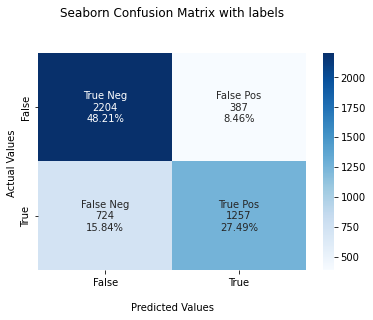

In [173]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

> # Summary of above trained models on both text as well as 18 numerical features:-

In [1]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable([ "Vectorizer","Model", "Accuracy On test Data","Precision on Test Data"])
  
# Add rows
myTable.add_row(["tfidf Vectorizer","Gaussian NB", "82.5", "77.1"])
myTable.add_row(["-------", "-------", "-------","-------"])
myTable.add_row(["tfidf Vectorizer","Decision Tree", "83.9", "86.7"])
myTable.add_row(["-------", "-------", "-------","-------"])
myTable.add_row(["tfidf Vectorizer","Logistic Regression", "97.6", "95.9"])
               
print(myTable)

+------------------+---------------------+-----------------------+------------------------+
|    Vectorizer    |        Model        | Accuracy On test Data | Precision on Test Data |
+------------------+---------------------+-----------------------+------------------------+
| tfidf Vectorizer |     Gaussian NB     |          82.5         |          77.1          |
|     -------      |       -------       |        -------        |        -------         |
| tfidf Vectorizer |    Decision Tree    |          83.9         |          86.7          |
|     -------      |       -------       |        -------        |        -------         |
| tfidf Vectorizer | Logistic Regression |          97.6         |          95.9          |
+------------------+---------------------+-----------------------+------------------------+


> # Observations:-
1. From above table we can see that after adding our 18 numerical features our accuracy and precesion both got inceased for all the three models
2. For KNN the results are very impresive as intially with only test features we were getting accuracy of 46.5% and precision of 44.7% but after adding our numerical feaures we are getting accuracy of 83.9% and precesion of 86.7%
3. Similary we can some improve of accuracy and precesion in Logistic rgression model as well

> # Below is table when all three model is trained only with text features using tfidf vectorization we can clearly see after adding our 18 manually engnieered numerical features our models performance got improved specially KNN

In [2]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable([ "Vectorizer","Model", "Accuracy On test Data","Precision on Test Data"])
  
# Add rows
myTable.add_row(["tfidf Vectorizer","Gaussian NB", "81.7", "75.2"])
myTable.add_row(["-------", "-------", "-------","-------"])
myTable.add_row(["tfidf Vectorizer","KNN", "46.5", "44.7"])
myTable.add_row(["-------", "-------", "-------","-------"])
myTable.add_row(["tfidf Vectorizer","Logistic Regression", "97.3", "95.2"])
               
print(myTable)

+------------------+---------------------+-----------------------+------------------------+
|    Vectorizer    |        Model        | Accuracy On test Data | Precision on Test Data |
+------------------+---------------------+-----------------------+------------------------+
| tfidf Vectorizer |     Gaussian NB     |          81.7         |          75.2          |
|     -------      |       -------       |        -------        |        -------         |
| tfidf Vectorizer |         KNN         |          46.5         |          44.7          |
|     -------      |       -------       |        -------        |        -------         |
| tfidf Vectorizer | Logistic Regression |          97.3         |          95.2          |
+------------------+---------------------+-----------------------+------------------------+
